In [ ]:
from google.colab import files
files.upload()  # Unggah file kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinawachidahseptiana","key":"53e1b4cc8bd38751f908a312ea2a329c"}'}

In [ ]:
!mkdir -p ~/.kaggle  # Membuat direktori .kaggle jika belum ada
!mv kaggle.json ~/.kaggle/  # Memindahkan file kaggle.json ke .kaggle
!chmod 600 ~/.kaggle/kaggle.json  # Mengatur izin file agar lebih aman

In [ ]:
# Unduh dataset ke direktori pilihan, misalnya /content/dataset
!kaggle datasets download -d syedalinaqvi/augmented-skin-conditions-image-dataset -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset
License(s): CC-BY-SA-4.0
100% 273M/273M [00:13<00:00, 25.6MB/s]
100% 273M/273M [00:13<00:00, 20.9MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/dataset/augmented-skin-conditions-image-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import matplotlib.pyplot as plt

In [ ]:
# 3. Load and Preprocess Dataset
dataset_path = '/content/dataset/Skin_Conditions'  # Update this if dataset structure changes

In [ ]:
# Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 2394 files belonging to 6 classes.


In [ ]:
# Class names
class_names = dataset.class_names
print("Detected Classes:", class_names)

Detected Classes: ['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']


In [ ]:
# Split dataset
def split_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1):
    total_size = len(dataset)
    train_end = int(total_size * train_size)
    val_end = train_end + int(total_size * val_size)

    train_dataset = dataset.take(train_end)
    val_dataset = dataset.skip(train_end).take(val_end - train_end)
    test_dataset = dataset.skip(val_end)

    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)
])

# Augmentasi dataset
def augment_data(dataset):
    def augment(image, label):
        image = data_augmentation(image)
        return image, label

    return dataset.map(augment)

train_dataset = augment_data(train_dataset)

In [ ]:
# 4. Load VGG16 pre-trained
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Tambahkan layer klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,3

 Total params: 14,847,558 (56.64 MB)

 Trainable params: 132,870 (519.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# 5. Train the Model
# Callback untuk menghentikan pelatihan jika tidak ada peningkatan
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Simpan model terbaik
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Melatih model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1196s 20s/step - accuracy: 0.2106 - loss: 4.9313 - val_accuracy: 0.3348 - val_loss: 1.9744
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1186s 20s/step - accuracy: 0.3346 - loss: 2.8197 - val_accuracy: 0.5045 - val_loss: 1.5305
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1172s 20s/step - accuracy: 0.3846 - loss: 2.3975 - val_accuracy: 0.6071 - val_loss: 1.1900
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1169s 20s/step - accuracy: 0.4402 - loss: 1.9489 - val_accuracy: 0.6473 - val_loss: 0.9484
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1171s 20s/step - accuracy: 0.4779 - loss: 1.6647 - val_accuracy: 0.6562 - val_loss: 0.9467
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1189s 20s/step - accuracy: 0.5392 - loss: 1.4090 - val_accuracy: 0.6473 - val_loss: 0.9323
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1172s 20s/step - accuracy: 0.5863 - loss: 1.3018 - val_accuracy: 0.6875 - val_loss: 0.9085
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1184s 20s/step - accuracy: 0.5969 - loss: 1.2549 - val_accu

In [ ]:
# 6. Evaluate the Model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 16s/step - accuracy: 0.7810 - loss: 0.6393
Test Accuracy: 0.7880


In [ ]:
# 7. Membuka beberapa layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-5]:  # Hanya fine-tune 5 layer terakhir
    layer.trainable = False

# Compile ulang model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune model
history_fine_tune = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1423s 24s/step - accuracy: 0.6875 - loss: 0.8320 - val_accuracy: 0.8170 - val_loss: 0.5024
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1396s 23s/step - accuracy: 0.7513 - loss: 0.7005 - val_accuracy: 0.8482 - val_loss: 0.4415
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1403s 23s/step - accuracy: 0.7861 - loss: 0.6078 - val_accuracy: 0.8214 - val_loss: 0.5677
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1408s 23s/step - accuracy: 0.8263 - loss: 0.4973 - val_accuracy: 0.8571 - val_loss: 0.4017
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1394s 23s/step - accuracy: 0.8373 - loss: 0.4674 - val_accuracy: 0.8795 - val_loss: 0.3822
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1393s 23s/step - accuracy: 0.8406 - loss: 0.4444 - val_accuracy: 0.8661 - val_loss: 0.3785
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1393s 23s/step - accuracy: 0.8657 - loss: 0.3930 - val_accuracy: 0.8616 - val_loss: 0.3899
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1395s 23s/step - accuracy: 0.8685 - loss: 0.3727 - val_accu

In [ ]:
# Evaluasi ulang
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy After Fine-Tuning: {test_acc:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 139s 16s/step - accuracy: 0.9389 - loss: 0.2391
Test Accuracy After Fine-Tuning: 0.9160


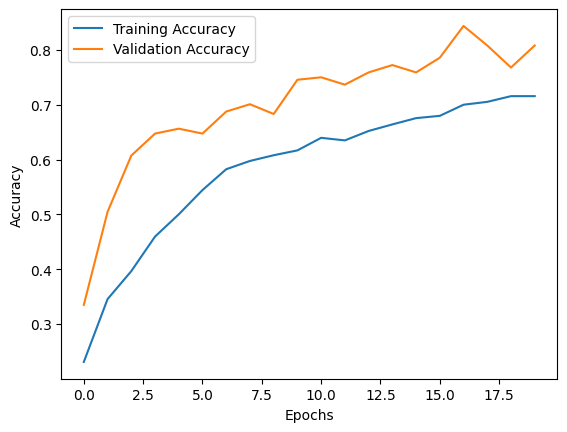

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


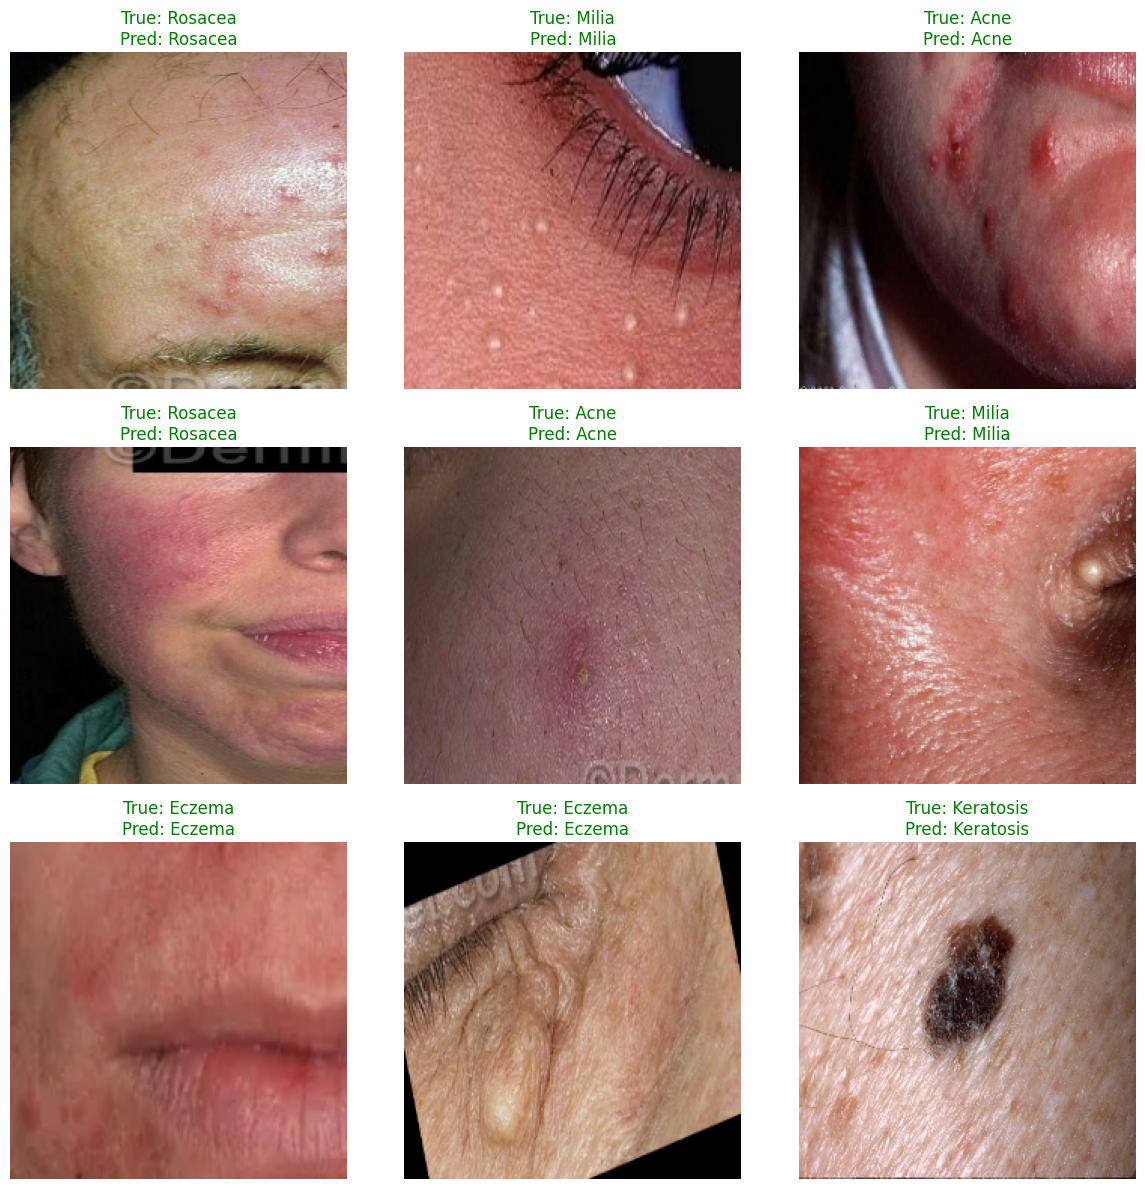

In [ ]:
# Plot akurasi training dan validasi
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history)

# Visualisasi hasil prediksi pada test dataset
def plot_random_images(test_dataset, model, class_names, num_images=9):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for image_batch, label_batch in test_dataset.take(1):
        predictions = model.predict(image_batch)
        predicted_labels = tf.argmax(predictions, axis=1)
        indices = np.random.choice(len(image_batch), num_images, replace=False)

        for idx, ax in enumerate(axes):
            img = image_batch[indices[idx]].numpy().astype(np.uint8)
            true_label = label_batch[indices[idx]].numpy()
            pred_label = predicted_labels[indices[idx]]

            ax.imshow(img)
            ax.axis('off')

            true_label_name = class_names[true_label]
            pred_label_name = class_names[pred_label]
            title_color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}", color=title_color, fontsize=12)

    plt.tight_layout()
    plt.show()

plot_random_images(test_dataset, model, class_names)